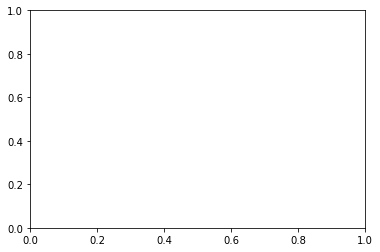

MovieWriter ffmpeg unavailable; using Pillow instead.


In [146]:
# snowflake simulation 

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.widgets import Button, Slider

alpha = 1
beta = 0.65
gamma = 0.001
u = 0
v = 0
neighbors = []
is_center = False

width = 61
height = 61
center = (width // 2 , height // 2)
num_neighbors = 4

# width x height matrix to store cell objects
# indexed by cell coordinates
cells = np.empty((width, height), dtype=object)

class Cell: 
    def __init__(self,s,coor,is_receptive):
        self.u = 0 #water used in diffusion (this models the "diffusion view" of the cells, zero-ing out the receptive cells)
        self.v = 0 #water not used in diffusion (this models the "non diffusion view" of the cells, zero-ing out the nonreceptive cells)
        self.s = s #total water 
        self.coor = coor
        self.next_u = 0 
        self.next_v = 0
        self.is_receptive = is_receptive
    def get_s(self):
        return self.s
        
#get the neighbors for a specific coordinate
#  o o o o o 
#  o x x o o
#  o x # x o 
#  o o x x o 
#  o o o o o 

def get_neighbors(coor): 
    global cells
    x, y = coor
    
    # hexagon #
    # corner cases:
    if x >= width-1 and y >= height-1: # top right corner
        neighbors = np.array([ cells[x-1,y], cells[x,y-1] ])
    elif x >= width-1 and y == 0: # bottom right corner
        neighbors = np.array([ cells[x-1,y], cells[x,y+1], cells[x-1, y+1] ])
    elif x == 0 and y >= height-1: # top left corner
        neighbors = np.array([ cells[x+1,y], cells[x,y-1], cells[x+1, y-1] ])
    elif x == 0 and y == 0: # bottom left corner
        neighbors = np.array([ cells[x+1,y], cells[x,y+1] ])
    
    # edges (excluding corners)
    elif x >= width-1 and y > 0 and y < height-1: # right edge
        neighbors = np.array([ cells[x-1,y], cells[x,y-1], cells[x,y+1], cells[x-1, y+1] ])
    elif x == 0 and y > 0 and y < height-1: # left edge
        neighbors = np.array([ cells[x+1,y], cells[x,y-1], cells[x,y+1], cells[x+1, y-1] ])
    elif y >= height-1 and x > 0 and x < width-1: # top edge
        neighbors = np.array([ cells[x-1,y], cells[x+1,y], cells[x,y-1], cells[x+1, y-1] ])
    elif y == 0 and x > 0 and x < width-1: # bottom edge
        neighbors = np.array([ cells[x-1,y], cells[x+1,y], cells[x,y+1], cells[x-1, y+1] ])
    else:
        neighbors = np.array([ cells[x-1,y],  cells[x+1,y], cells[x,y-1], cells[x,y+1], cells[x-1, y+1], cells[x+1, y-1] ])
    return neighbors

## OCTOGON ##
    # corner cases:
#     if x >= width-1 and y >= height-1: # top right corner
#         neighbors = np.array([ cells[x-1,y], cells[x,y-1], cells[x-1, y-1] ])
#     elif x >= width-1 and y == 0: # bottom right corner
#         neighbors = np.array([ cells[x-1,y], cells[x,y+1], cells[x-1, y+1] ])
#     elif x == 0 and y >= height-1: # top left corner
#         neighbors = np.array([ cells[x+1,y], cells[x,y-1], cells[x+1, y-1] ])
#     elif x == 0 and y == 0: # bottom left corner
#         neighbors = np.array([ cells[x+1,y], cells[x,y+1], cells[x+1, y+1] ])
    
#     # edges (excluding corners)
#     elif x >= width-1 and y > 0 and y < height-1: # right edge
#         neighbors = np.array([ cells[x-1,y], cells[x,y-1], cells[x,y+1], cells[x-1, y+1], cells[x-1, y-1] ])
#     elif x == 0 and y > 0 and y < height-1: # left edge
#         neighbors = np.array([ cells[x+1,y], cells[x,y-1], cells[x,y+1], cells[x+1, y-1], cells[x+1, y+1] ])
#     elif y >= height-1 and x > 0 and x < width-1: # top edge
#         neighbors = np.array([ cells[x-1,y], cells[x+1,y], cells[x,y-1], cells[x+1, y-1], cells[x-1, y-1] ])
#     elif y == 0 and x > 0 and x < width-1: # bottom edge
#         neighbors = np.array([ cells[x-1,y], cells[x+1,y], cells[x,y+1], cells[x-1, y+1], cells[x+1, y+1] ])
#     else:
#         neighbors = np.array([ cells[x-1,y],  cells[x+1,y], cells[x,y-1], cells[x,y+1], cells[x-1, y+1], cells[x+1, y-1], cells[x-1, y-1], cells[x+1, y+1] ])
#     return neighbors

# initialize grid
for i in range(width):
    for j in range(height):
        coordinate = (i,j)
        if coordinate == center: 
            is_center = True
            cells[i, j] = Cell(s=1, coor=coordinate, is_receptive=is_center)
        else:
            is_center = False
            cells[i, j] = Cell(s=beta, coor=coordinate, is_receptive=is_center)
            
# actual implementation
def one_iter():
    global cells
    # step 1: determine receptive sites
    for row in cells:
        for cell in row:
            if cell.is_receptive: # this is a receptive cell
                cell.u = 0
                cell.v = cell.s
                cell.next_v = cell.v + gamma
            else:
                cell.u = cell.s
                cell.v = 0
            
    # step 2: modify cell values
    for row in cells:
        for cell in row:   
            # determine the effects of diffusion    
            neighbors = get_neighbors(cell.coor)
            sum = 0
            for neighbor in neighbors:
                sum += neighbor.u
            u_avg = sum / (neighbors.size)
            # diffusion equation (laplace approximation)
            cell.next_u = cell.u + alpha / 2 * (u_avg - cell.u)
            
            # now update the cell
            cell.s = cell.next_u + cell.next_v
            if cell.s >= 1: # we are frozen, so we are receptive
                cell.is_receptive = True
    # last loop: must have all s values updated to determine new boundary cells
    for row in cells:
        for cell in row:
            if not cell.is_receptive:
                neighbors = get_neighbors(cell.coor)
                for neighbor in neighbors:
                    if neighbor.s >= 1: #we have at least one neighbor that is frozen
                        cell.is_receptive = True
                        break

# plotting
fig = plt.figure()
ax = plt.gca()

s_vals = np.empty((width, height), dtype=float)
frozen_cells = np.empty((width, height), dtype=float)

def update_s_vals(): 
    global s_vals
    global cells
    global frozen_cells
    for i in range(width):
        for j in range(height):
            s_vals[i,j] = cells[i,j].s 
            if (cells[i,j].s >= 1):
                frozen_cells[i,j] = 1
            else:
                frozen_cells[i,j] = 0

# plot = ax.imshow(frozen_cells,animated=True)
def update(frame):
    global s_vals
    global frozen_cells
    ax.clear
    one_iter()
    update_s_vals()
    plot = ax.imshow(frozen_cells,animated=True)
    return plot
    

# update()
# plt.show()
# print(update(1))

anim = FuncAnimation(fig=fig, func=update, frames=150)
plt.show()
anim.save('animated.gif', fps=30)
